In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

df = pd.read_csv("/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv")

df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [2]:
import os
import cv2
from os import listdir

X = []
image_names = []
folder_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        n = cv2.imread(os.path.join(folder_dir,images))
        X.append(n)
        image_names.append(images)

In [3]:
len(X)

10015

In [4]:
df['label'] = df.iloc[:, 1:].idxmax(axis=1).map({
    'MEL': 0,
    'NV': 1,
    'BCC': 2,
    'AKIEC': 3,
    'BKL': 4,
    'DF': 5,
    'VASC': 6
})
df = df.drop(columns=['MEL','NV','BCC','AKIEC','BKL','DF','VASC'])

df.head()

,image,label
0,ISIC_0024306,1
1,ISIC_0024307,1
2,ISIC_0024308,1
3,ISIC_0024309,1
4,ISIC_0024310,0


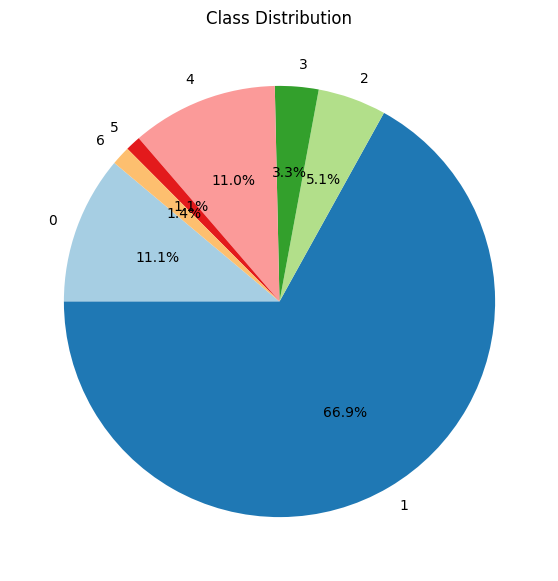

In [5]:
import matplotlib.pyplot as plt
class_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Class Distribution')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,random_split

X_train, X_valid, y_train, y_valid = train_test_split(X, df["label"], test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_valid,y_valid, test_size=0.5, random_state=42)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToPILImage(),            
    transforms.Resize((128, 128)),      
    transforms.ToTensor(),        
    transforms.Normalize( 
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Custom Dataset class
class SkinDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

X_train_tensor = [transform(img) for img in X_train]
X_val_tensor = [transform(img) for img in X_val]
X_test_tensor = [transform(img) for img in X_test]

train_dataset = SkinDataset(X_train_tensor, y_train)
val_dataset = SkinDataset(X_val_tensor, y_val)
test_dataset = SkinDataset(X_test_tensor, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskModel, self).__init__()
        
        # Shared backbone (simple CNN example)
        self.shared_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
        # Segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),  # 1 for binary segmentation
            nn.Sigmoid()
        )
        
    def forward(self, x):
        shared_features = self.shared_conv(x)
        
        # Classification output
        class_out = self.classifier(shared_features)
        
        # Segmentation output
        seg_out = F.interpolate(
            self.segmentation_head(shared_features), 
            size=x.shape[2:],  # Resize to input image size
            mode='bilinear', align_corners=False
        )
        
        return class_out

In [11]:
criterion_classification = nn.CrossEntropyLoss()  # For classification task
criterion_segmentation = nn.BCELoss()  # Binary Cross-Entropy for segmentation
import torch.optim as optim

# Model instantiation
num_classes = 7
model = MultiTaskModel(num_classes=num_classes)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example training loop
for epoch in range(10):  # Example: 10 epochs
    model.train()
    for images, (class_labels) in train_loader:
        images, class_labels = images.to(device), class_labels.to(device)
        
        # Forward pass
        class_output = model(images)
        
        # Compute classification and segmentation loss
        loss_classification = criterion_classification(class_output, class_labels)
        
        # Total loss (you can weight the losses if needed)
        total_loss = loss_classification
        
        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/10], Loss: {total_loss.item():.4f}")


Epoch [1/10], Loss: 1.6408
Epoch [2/10], Loss: 1.2071
Epoch [3/10], Loss: 1.0371
Epoch [4/10], Loss: 1.0453
Epoch [5/10], Loss: 1.3014
Epoch [6/10], Loss: 1.1897
Epoch [7/10], Loss: 0.7406
Epoch [8/10], Loss: 1.1719
Epoch [9/10], Loss: 1.4109
Epoch [10/10], Loss: 0.8803


In [12]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    all_class_preds = []
    all_class_labels = []
    
    with torch.no_grad():
        for images, (class_labels) in val_loader:
            images, class_labels = images.to(device), class_labels.to(device)
            
            # Forward pass
            class_output = model(images)
            
            # ---- Classification Metrics ----
            # Get predicted class labels
            _, class_preds = torch.max(class_output, 1)
            all_class_preds.extend(class_preds.cpu().numpy())
            all_class_labels.extend(class_labels.cpu().numpy())
    
    # ---- Compute Final Classification Metrics ----
    accuracy = accuracy_score(all_class_labels, all_class_preds)
    precision = precision_score(all_class_labels, all_class_preds, average='weighted')
    recall = recall_score(all_class_labels, all_class_preds, average='weighted')
    f1 = f1_score(all_class_labels, all_class_preds, average='weighted')

    
    print("Classification Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate(model, val_loader, device)

Classification Metrics:
Accuracy: 0.6693
Precision: 0.4480
Recall: 0.6693
F1-Score: 0.5367


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
evaluate(model,test_loader,device)

Classification Metrics:
Accuracy: 0.6669
Precision: 0.4448
Recall: 0.6669
F1-Score: 0.5337


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
